In [40]:
pip install scikit-learn


  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 6.6 MB/s eta 0:00:00a 0:00:01
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

/home/emine2/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [11]:
#ins = pd.read_csv('/home/emine2/CPSC-499/data/insurance_with_weather.csv')
ins = pd.read_csv('/home/emine2/CPSC-499/data/insurance_with_weather_cleaned.csv')
ins

,commodity_year_identifier,state_abbreviation,county_code,county_name,commodity_code,cause_of_loss_code,cause_of_loss_description,month_of_loss,policies_indemnified,net_planted_quantity,...,subsidy,state/private_subsidy,additional_subsidy,efa_premium_discount,net_determined_quantity,indemnity_amount,loss_ratio,county_fips,total_precipitation_m,temperature_K
0,2016,IL,1,Adams,41,11,drought,8,1,68.000000,...,1767.0,0.0,0.0,0.0,68.0000,5723.0,1.78,17001,0.002598,298.068945
1,2016,IL,1,Adams,41,11,drought,11,1,28.900000,...,733.0,0.0,0.0,0.0,28.9000,3409.0,1.77,17001,0.001104,282.686963
2,2016,IL,1,Adams,41,11,drought,6,2,63.550000,...,1506.5,0.0,0.0,0.0,71.2000,2362.0,0.67,17001,0.004493,299.282715
3,2016,IL,1,Adams,41,11,drought,6,1,13.550000,...,261.5,0.0,0.0,0.0,5.9000,338.0,0.49,17001,0.004493,299.282715
4,2016,IL,1,Adams,41,11,drought,10,1,56.400000,...,1079.0,0.0,0.0,0.0,56.4000,14447.0,5.09,17001,0.001843,289.454004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51378,2024,IL,203,Woodford,81,31,excess-moisture,5,1,210.630000,...,500.0,0.0,0.0,0.0,93.0000,3222.0,2.45,17203,0.003036,292.451823
51379,2024,IL,203,Woodford,81,31,excess-moisture,10,1,11.090551,...,35.5,0.0,0.0,0.0,22.1811,333.0,3.56,17203,0.004033,288.004150
51380,2024,IL,203,Woodford,81,31,excess-moisture,6,1,82.501497,...,263.5,0.0,0.0,0.0,51.6770,1790.0,2.58,17203,0.004996,297.068034
51381,2024,IL,203,Woodford,81,31,excess-moisture,6,6,913.720000,...,10907.0,0.0,0.0,0.0,264.4700,12489.0,0.59,17203,0.004996,297.068034


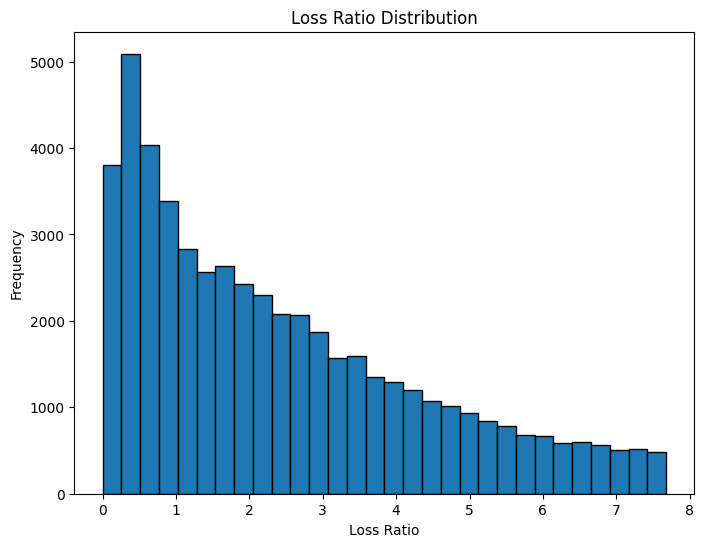

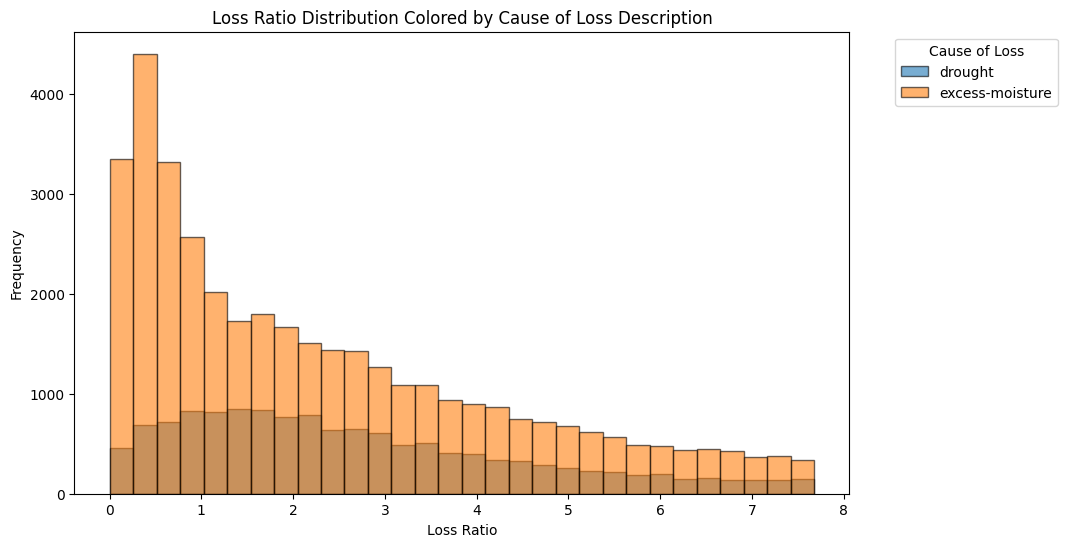

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(ins['loss_ratio'], bins=30, edgecolor='black')
plt.xlabel('Loss Ratio')
plt.ylabel('Frequency')
plt.title('Loss Ratio Distribution')
plt.show()
plt.figure(figsize=(10, 6))
for desc, group in ins.groupby('cause_of_loss_description'):
    plt.hist(group['loss_ratio'], bins=30, alpha=0.6, label=desc, edgecolor='black')
plt.xlabel('Loss Ratio')
plt.ylabel('Frequency')
plt.title('Loss Ratio Distribution Colored by Cause of Loss Description')
plt.legend(title='Cause of Loss', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## dont run the below code after once clean and write the data

In [3]:
# outliers
Q1 = ins['loss_ratio'].quantile(0.10)
Q3 = ins['loss_ratio'].quantile(0.60)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

# Filter the outliers
outliers_df = ins[
    (ins['loss_ratio'] > upper_bound)
].copy()

ins = ins[
    (ins['loss_ratio'] <= upper_bound)
].copy()

print(f"Found {len(outliers_df)} outliers out of {len(ins)} records.")

Found 4178 outliers out of 47205 records.


In [4]:
# Filter out rows with negative loss_ratio values into a new DataFrame
negative_loss = ins[ins['loss_ratio'] < 0].copy()

# Remove rows with negative loss_ratio values from the original DataFrame
ins = ins[ins['loss_ratio'] >= 0]

# Save the negative loss_ratio rows to a CSV file
#negative_loss.to_csv('negative_loss_ratio.csv', index=False)
negative_loss.head()

,commodity_year_identifier,state_abbreviation,county_code,county_name,commodity_code,cause_of_loss_code,cause_of_loss_description,month_of_loss,policies_indemnified,net_planted_quantity,...,subsidy,state/private_subsidy,additional_subsidy,efa_premium_discount,net_determined_quantity,indemnity_amount,loss_ratio,county_fips,total_precipitation_m,temperature_K


In [6]:
selected_vars = [
    'commodity_year_identifier', 'state_abbreviation',
    'county_code', 'county_name', 'commodity_code',
    'cause_of_loss_code', 'cause_of_loss_description',
    'month_of_loss', 'policies_indemnified',
    'net_planted_quantity', 'net_endorsed_acres', 'liability',
    'total_premium', 'producer_paid_premium', 'subsidy',
    'state/private_subsidy', 'additional_subsidy', 'efa_premium_discount',
    'net_determined_quantity', 'indemnity_amount', 'loss_ratio',
    'county_fips', 'total_precipitation_m', 'temperature_K'
]

ins = ins[selected_vars]
       

In [7]:
ins.to_csv('/home/emine2/CPSC-499/data/insurance_with_weather_cleaned.csv', index=False)

## until this point

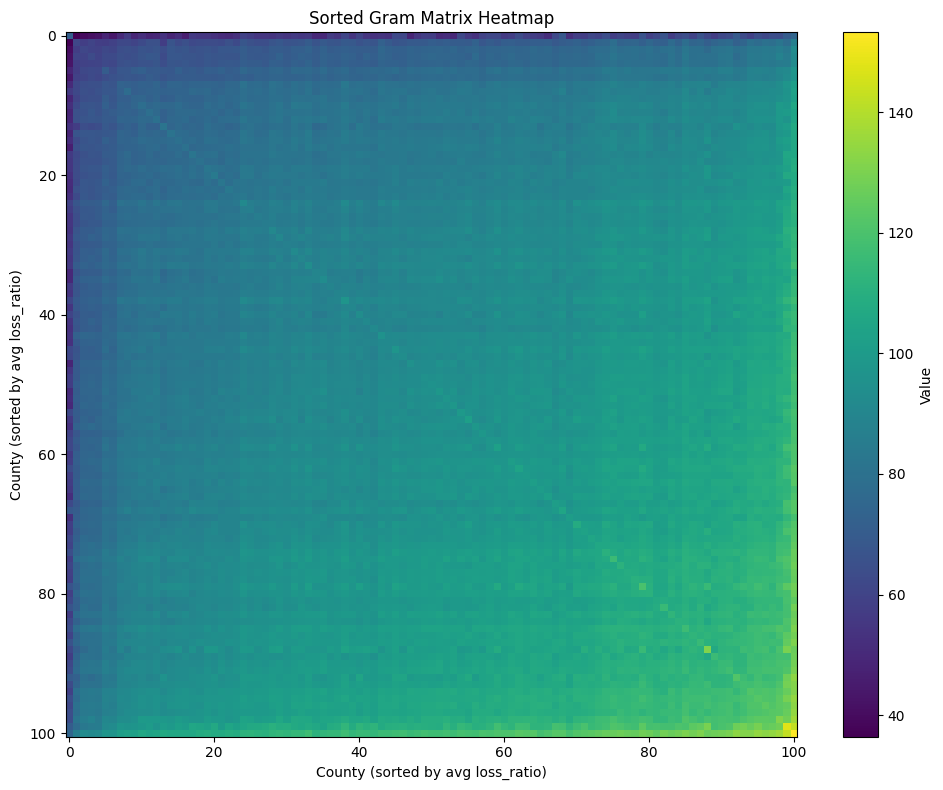

county_fips,17069,17041,17115,17139,17029,17153,17021,17019,17147,17059,...,17121,17143,17123,17133,17169,17081,17149,17109,17155,17125
county_fips,,,,,,,,,,,,,,,,,,,,,
17069,71.983051,36.438456,40.352409,41.820538,43.205413,48.324380,44.008224,50.559750,56.721706,49.084602,...,63.748835,69.941409,62.963619,58.959537,64.591774,61.871951,64.317680,64.170493,70.394059,74.530031
17041,36.438456,61.320779,58.191772,60.203829,57.925599,57.686435,59.038181,61.934899,61.780390,60.438149,...,77.134195,72.865732,74.664385,79.359417,77.688798,79.892837,78.899429,81.745574,78.407332,86.916404
17115,40.352409,58.191772,61.156033,60.099899,59.517868,61.824450,61.030402,64.560083,64.946451,64.661993,...,82.225656,79.375183,80.262017,83.225278,83.378561,84.533065,83.738560,86.007510,83.362383,92.731639
17139,41.820538,60.203829,60.099899,63.198993,59.863935,62.668978,62.758581,64.770626,64.691117,65.060510,...,82.600075,77.709975,80.302623,84.562597,83.511541,84.925649,84.549649,88.287758,85.111870,91.834156
17029,43.205413,57.925599,59.517868,59.863935,60.496606,62.272989,61.315138,65.179933,65.686715,65.161711,...,82.601313,80.145450,80.312123,83.779163,83.149908,84.435876,83.333095,85.109483,85.669259,92.571701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,61.871951,79.892837,84.533065,84.925649,84.435876,88.369600,86.748311,91.435665,92.241207,93.754339,...,118.831426,115.140996,117.861804,120.931809,121.027941,123.753923,121.516156,123.978468,125.326197,132.817587
17149,64.317680,78.899429,83.738560,84.549649,83.333095,87.458504,87.575768,91.019400,93.411102,93.474399,...,118.844702,116.046668,117.557789,120.262501,120.418195,121.516156,122.808792,123.172789,125.918269,134.227242
17109,64.170493,81.745574,86.007510,88.287758,85.109483,90.705919,89.731476,93.509747,93.494165,95.118596,...,118.655890,118.055259,120.803918,122.538730,123.769274,123.978468,123.172789,131.563839,127.913370,136.620063


In [12]:
# 1) Pivot
county_loss_matrix = ins.pivot_table(
    index='county_fips',
    columns='commodity_year_identifier',
    values='loss_ratio',
    fill_value=0
)

# 2) Sort counties by their average loss_ratio
county_score     = county_loss_matrix.mean(axis=1)
sorted_counties  = county_score.sort_values(ascending=True).index

# 3) Compute the Gram matrix (counties × counties)
gram = county_loss_matrix.dot(county_loss_matrix.T)

# 4) Reorder the Gram matrix on both axes
gram_sorted = gram.loc[sorted_counties, sorted_counties]

# 5) Plot
plt.figure(figsize=(10,8))
plt.imshow(gram_sorted.values, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Sorted Gram Matrix Heatmap')
plt.xlabel('County (sorted by avg loss_ratio)')
plt.ylabel('County (sorted by avg loss_ratio)')
plt.tight_layout()
plt.show()
gram_sorted


In [13]:
import pandas as pd
import numpy as np
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

county_loss = ins.pivot_table(
    index='county_fips',
    columns='commodity_year_identifier',
    values='loss_ratio',
    fill_value=0
)

# --- 1) Gram matrix ---
gram = county_loss.dot(county_loss.T)

# --- 2) Spectral embedding on the Gram (2 dimensions) ---
embedder = SpectralEmbedding(n_components=2, affinity='precomputed')
emb = embedder.fit_transform(gram.values)
embed_df = (
    pd.DataFrame(emb, index=gram.index, columns=['dim1','dim2'])
      .reset_index()
      .rename(columns={'index':'county_fips'})
)
embed_df


,county_fips,dim1,dim2
0,17001,-0.000748,0.000545
1,17003,-0.000655,0.001518
2,17005,-0.001612,0.001055
3,17007,0.000525,-0.000355
4,17009,-0.000101,0.000952
...,...,...,...
96,17195,0.000796,0.000680
97,17197,0.000014,-0.000847
98,17199,0.000053,0.000001
99,17201,0.001173,-0.001210


In [14]:
# --- 3) Load  weather covariates (must have county_fips, avg_temp, avg_precip) ---
weather = ins[['total_precipitation_m', 'temperature_K', 'county_fips']].copy()
weather.rename(columns={'total_precipitation_m': 'avg_precip', 'temperature_K': 'avg_temp'}, inplace=True)
# --- 3) Load  weather covariates (must have county_fips, avg_temp, avg_precip) ---
weather = ins[['total_precipitation_m', 'temperature_K', 'county_fips']].copy()
weather.rename(columns={'total_precipitation_m': 'avg_precip', 'temperature_K': 'avg_temp'}, inplace=True)
weather = weather.groupby('county_fips', as_index=False).mean()
weather = weather.fillna(weather.mean())
weather


,county_fips,avg_precip,avg_temp
0,17001,0.002984,291.893190
1,17003,0.003078,292.142004
2,17005,0.003147,293.310634
3,17007,0.002687,288.981908
4,17009,0.003296,292.582726
...,...,...,...
96,17195,0.003031,289.898695
97,17197,0.003000,290.122646
98,17199,0.003191,296.196719
99,17201,0.002675,289.359501


In [15]:
# --- 4) Merge and compute correlations ---
merged = embed_df.merge(weather, on='county_fips')

# Pearson r between each embedding dim and each covariate
for dim in ['dim1','dim2']:
    for cov in ['avg_temp','avg_precip']:
        r, p = pearsonr(merged[dim], merged[cov])
        print(f"Corr({cov}, {dim}) = {r:.3f}, p‐value = {p:.3g}")

# --- 5) K-Means clustering on the embedding ---
kmeans = KMeans(n_clusters=3, random_state=0).fit(emb)
cluster_df = (
    pd.DataFrame({
        'county_fips': gram.index,
        'cluster': kmeans.labels_
    })
)

# Merge clusters with weather and report cluster means
clustered = cluster_df.merge(weather, on='county_fips')
cluster_stats = clustered.groupby('cluster')[['avg_temp','avg_precip']].agg(['mean','std','count'])
print("\nPer‐cluster weather summary:")
print(cluster_stats)
clustered


Corr(avg_temp, dim1) = -0.269, p‐value = 0.00653
Corr(avg_precip, dim1) = -0.317, p‐value = 0.00124
Corr(avg_temp, dim2) = 0.249, p‐value = 0.0119
Corr(avg_precip, dim2) = 0.167, p‐value = 0.0944

Per‐cluster weather summary:
           avg_temp                 avg_precip                
               mean       std count       mean       std count
cluster                                                       
0        291.248686  1.730627    46   0.003023  0.000173    46
1        292.902978  1.828819    54   0.003125  0.000107    54
2        292.142004       NaN     1   0.003078       NaN     1


,county_fips,cluster,avg_precip,avg_temp
0,17001,1,0.002984,291.893190
1,17003,1,0.003078,292.142004
2,17005,1,0.003147,293.310634
3,17007,0,0.002687,288.981908
4,17009,1,0.003296,292.582726
...,...,...,...,...
96,17195,1,0.003031,289.898695
97,17197,0,0.003000,290.122646
98,17199,1,0.003191,296.196719
99,17201,0,0.002675,289.359501


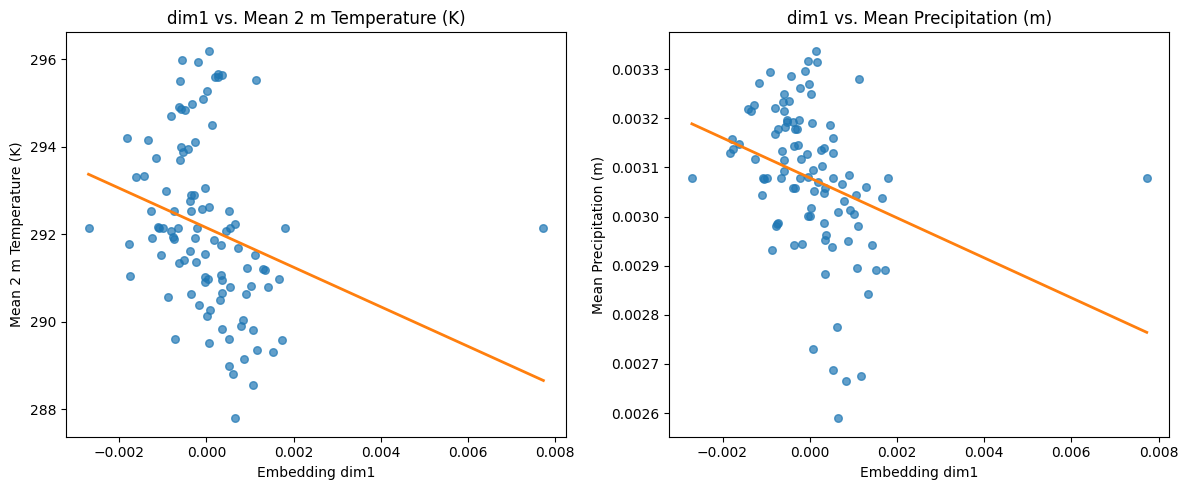

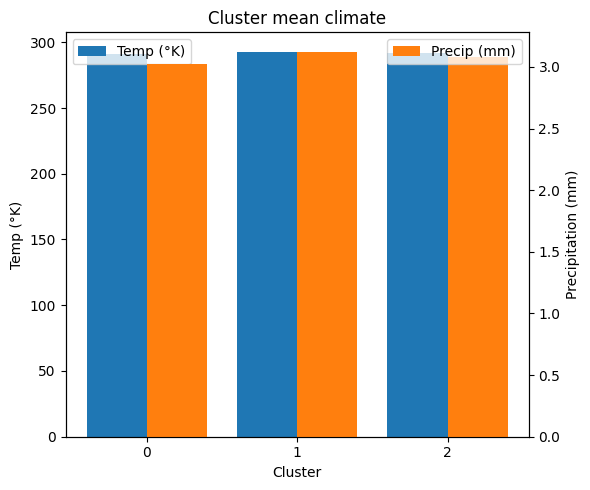

In [16]:
import matplotlib.pyplot as plt
import numpy as np



# 1) Scatter plots with regression line
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, covar, ylabel in zip(
    axes,
    ["avg_temp", "avg_precip"],
    ["Mean 2 m Temperature (K)", "Mean Precipitation (m)"]
):
    x = merged["dim1"]
    y = merged[covar]
    # scatter
    ax.scatter(x, y, s=30, alpha=0.7)
    # line‐of‐best‐fit
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, m*xs + b, color="C1", lw=2)
    ax.set_xlabel("Embedding dim1")
    ax.set_ylabel(ylabel)
    ax.set_title(f"dim1 vs. {ylabel}")

plt.tight_layout()
plt.show()

# 2) Cluster bar‐charts
# Compute cluster means
cluster_means = (
    clustered.groupby("cluster")[["avg_temp","avg_precip"]]
             .mean()
             .reset_index()
)

fig, ax1 = plt.subplots(figsize=(6,5))
ind = cluster_means["cluster"].astype(int)

# Bar for temperature (left axis)
ax1.bar(ind - 0.2, cluster_means["avg_temp"], width=0.4, label="Temp (°K)")
ax1.set_ylabel("Temp (°K)")
ax1.set_xlabel("Cluster")
ax1.set_xticks(ind)
ax1.set_title("Cluster mean climate")
ax1.legend(loc="upper left")

# Twin axis for precipitation
ax2 = ax1.twinx()
ax2.bar(ind + 0.2, cluster_means["avg_precip"]*1000, width=0.4, color="C1", label="Precip (mm)")
ax2.set_ylabel("Precipitation (mm)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 0) have:
#    county_loss_matrix: DataFrame (counties × features)
#    gram:               DataFrame (counties × counties), gram = X @ X.T
#    And you choose a “target” to predict, e.g. each county’s loss_ratio in 2025:
y = county_loss_matrix.mean(axis=1)
common = gram.index.intersection(y.index)
print("Counties with averaged loss:", len(common))  # equals number of counties

# build K and y arrays
K = gram.loc[common, common].values
y = y.loc[common].values

# --- 1) Split counties into train / test
#  split the *indices* so can slice K appropriately:
train_idx, test_idx = train_test_split(
    np.arange(len(common)), test_size=0.2, random_state=0
)

# Kernel for training: K_train = K[train, train]
K_train = K[np.ix_(train_idx, train_idx)]
y_train = y[train_idx]

# Kernel for testing: K_test = K[test, train]
K_test = K[np.ix_(test_idx, train_idx)]
y_test  = y[test_idx]

# --- 2) SVM with precomputed kernel
svr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
svr.fit(K_train, y_train)

y_pred_svr = svr.predict(K_test)
print("SVM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))

# --- 3) Gaussian Process with DotProduct kernel
# This kernel computes K(x, x') = x · x' + c, so if you pass the raw county‐vectors
# into GPR, it effectively learns on the same geometry as your Gram.
from sklearn.preprocessing import StandardScaler

X = county_loss_matrix.loc[common].values  # original data matrix
# standardize so dot‐product scales nicely
X = StandardScaler().fit_transform(X)

X_train = X[train_idx]
X_test  = X[test_idx]

# DotProduct + noise term
kernel = DotProduct(sigma_0=1.0)**2 + WhiteKernel(noise_level=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
gpr.fit(X_train, y_train)

y_pred_gpr, y_std = gpr.predict(X_test, return_std=True)
print("GPR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gpr)))

# --- 4) Inspect results
results = pd.DataFrame({
    "county_fips": common[test_idx],
    "y_true":      y_test,
    "svr_pred":    y_pred_svr,
    "gpr_pred":    y_pred_gpr,
    "gpr_std":     y_std
})
print(results.head())


Counties with averaged loss: 101
SVM RMSE: 0.09611408252243016
GPR RMSE: 1.1798331052701174
   county_fips    y_true  svr_pred  gpr_pred   gpr_std
0        17055  2.241470  2.265554  2.329167  0.924885
1        17175  2.134531  2.196889  2.832397  3.130889
2        17005  2.316689  2.316447  2.154535  1.306780
3        17113  2.111693  2.150108  2.071411  1.686342
4        17153  1.883051  2.001420  2.114009  2.972031


/home/emine2/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


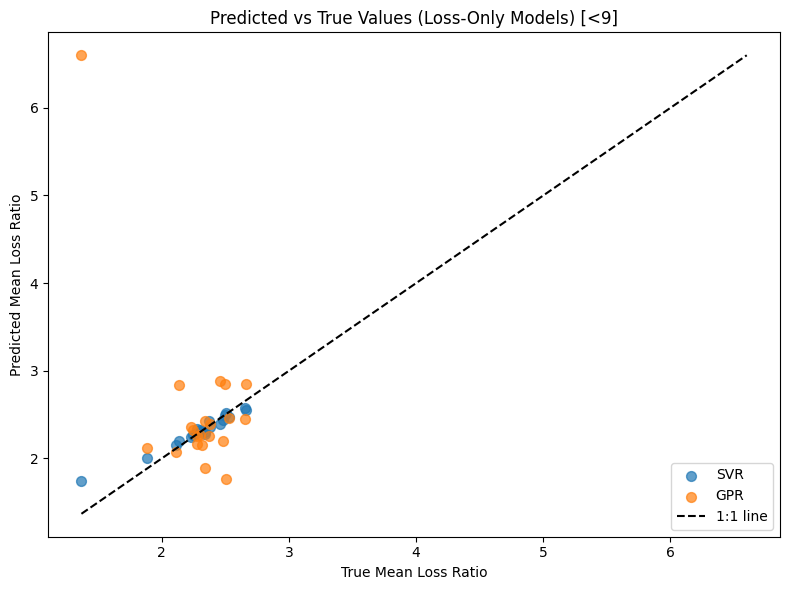

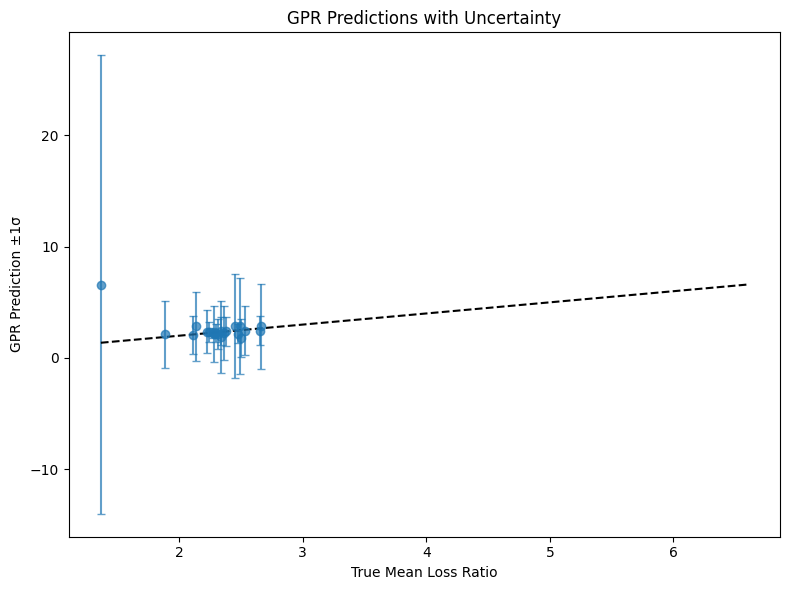

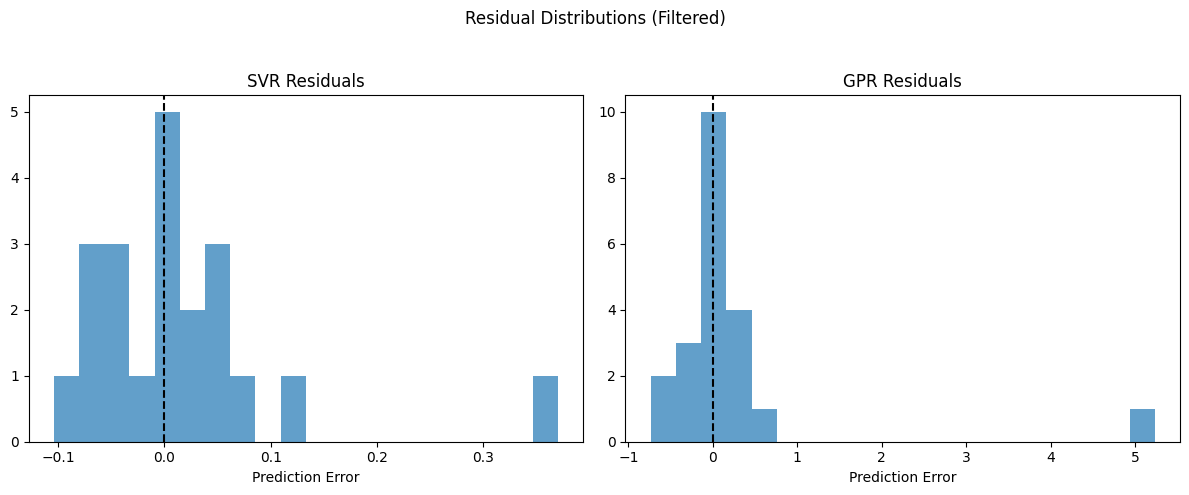

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define  cutoff
threshold = 9.0

# Mask out the outlier point(s)
mask = (
    (results['y_true']    < threshold) &
    (results['svr_pred']  < threshold) &
    (results['gpr_pred']  < threshold)
)
df_plot = results[mask]

# 1) Scatter: True vs. Predicted (filtered)
plt.figure(figsize=(8,6))
plt.scatter(df_plot['y_true'], df_plot['svr_pred'],
            label='SVR', alpha=0.7, s=50)
plt.scatter(df_plot['y_true'], df_plot['gpr_pred'],
            label='GPR', alpha=0.7, s=50)

lo = df_plot[['y_true','svr_pred','gpr_pred']].min().min()
hi = df_plot[['y_true','svr_pred','gpr_pred']].max().max()
plt.plot([lo, hi], [lo, hi], 'k--', label='1:1 line')

plt.xlabel('True Mean Loss Ratio')
plt.ylabel('Predicted Mean Loss Ratio')
plt.title('Predicted vs True Values (Loss‐Only Models) [<9]')
plt.legend()
plt.tight_layout()
plt.show()

# 2) GPR Uncertainty (filtered)
plt.figure(figsize=(8,6))
plt.errorbar(
    df_plot['y_true'], df_plot['gpr_pred'],
    yerr=df_plot['gpr_std'], fmt='o', alpha=0.7, capsize=3
)
plt.plot([lo, hi], [lo, hi], 'k--')
plt.xlabel('True Mean Loss Ratio')
plt.ylabel('GPR Prediction ±1σ')
plt.title('GPR Predictions with Uncertainty')
plt.tight_layout()
plt.show()

# 3) Residual Histograms (filtered)
res_svr = df_plot['svr_pred'] - df_plot['y_true']
res_gpr = df_plot['gpr_pred'] - df_plot['y_true']

fig, axs = plt.subplots(1, 2, figsize=(12,5))
bins = 20

axs[0].hist(res_svr, bins=bins, alpha=0.7)
axs[0].axvline(0, color='k', linestyle='--')
axs[0].set_title('SVR Residuals')
axs[0].set_xlabel('Prediction Error')

axs[1].hist(res_gpr, bins=bins, alpha=0.7)
axs[1].axvline(0, color='k', linestyle='--')
axs[1].set_title('GPR Residuals')
axs[1].set_xlabel('Prediction Error')

plt.suptitle('Residual Distributions (Filtered)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Stack with Weather Data
1. Line up everyone - weather and losses
2. put weather on the same scale - standardize (subtract each column's average and divide by its typical spread)
3. Glue past losses and weather together (stack features) 
4. Measure county-tocounty similarity (gram matrix) - How much do county A and county B look alike if consider both theri loss histories and weather. The result is a square matrix K where cell is a single number capturing that similarity. 
5. decide target variable
6. train - test split
7. Teach a support vector regression model
    - SVR with precomputed kernel
    - teach a gaussian process model -> instead of feeding it just K, here the raw stacked features (loss and weather) for each county. A gaussian process learns a smooth functions that passes through those feature points, and it even tell how confident it is in each prediction


## Both model see the same combined information but they ingest it in different ways
1. SVR with a precomputed kernel --> X-combind by horizontallu stacking the loss history and the scaled weather columns. Then the gram matrix was formed. SVR only sees the taw columns individually, which were computed from the stacked data. SVR is trained on the loss + weather data, but only in the form of a kernel. 
2. GPR --> GPR was handed the raw feature matrix X-combined directly (loss + weather) for each county. It fits a function in that original feature space and can even give a confidence estimate for each prediction. 

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 0) have:
#    county_loss_matrix: DataFrame (county_fips × loss‐features)
#    gram_loss          : DataFrame (county_fips × county_fips) = loss @ loss.T
#    weather: DataFrame with columns ['county_fips','avg_temp','avg_precip']

# --- 1) Align counties
common = county_loss_matrix.index.intersection(weather['county_fips'])
X_loss = county_loss_matrix.loc[common].values         # (n_counties × n_years)
weather_sub = weather.set_index('county_fips').loc[common]
X_weather = weather_sub[['avg_temp','avg_precip']].values  # (n_counties × 2)

# --- 2) Standardize weather, then stack
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

# Final feature matrix
X_combined = np.hstack([X_loss, X_weather_scaled])  
# Compute new Gram
K = X_combined @ X_combined.T          # shape: (n_counties × n_counties)

# --- 3) Prepare target: long‐term mean loss
y = county_loss_matrix.mean(axis=1).loc[common].values

# --- 4) Train/test split on the indices
idx = np.arange(len(common))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=0)

K_train = K[np.ix_(train_idx, train_idx)]
K_test  = K[np.ix_(test_idx,  train_idx)]
y_train = y[train_idx]
y_test  = y[test_idx]

# --- 5) SVR with combined kernel
svr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
svr.fit(K_train, y_train)
y_pred_svr = svr.predict(K_test)
print("SVR+weather RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))

# --- 6) GPR on the augmented features
X_train = X_combined[train_idx]
X_test  = X_combined[test_idx]

kernel = DotProduct()**2 + WhiteKernel(noise_level=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr.fit(X_train, y_train)
y_pred_gpr, y_std = gpr.predict(X_test, return_std=True)
print("GPR+weather RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gpr)))

# --- 7) Compare
results = pd.DataFrame({
    'county_fips': common[test_idx],
    'y_true':      y_test,
    'svr+weather': y_pred_svr,
    'gpr+weather': y_pred_gpr,
    'gpr_std':     y_std
})
print(results.head())
results


SVR+weather RMSE: 0.10025048158168277
GPR+weather RMSE: 0.3048395589193467
   county_fips    y_true  svr+weather  gpr+weather   gpr_std
0        17055  2.241470     2.285524     2.286536  0.604081
1        17175  2.134531     2.181749     2.218921  1.027058
2        17005  2.316689     2.298792     2.334789  0.461585
3        17113  2.111693     2.141125     2.155634  0.740069
4        17153  1.883051     2.010948     1.896722  1.177689


/home/emine2/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,county_fips,y_true,svr+weather,gpr+weather,gpr_std
0,17055,2.241470,2.285524,2.286536,0.604081
1,17175,2.134531,2.181749,2.218921,1.027058
2,17005,2.316689,2.298792,2.334789,0.461585
3,17113,2.111693,2.141125,2.155634,0.740069
4,17153,1.883051,2.010948,1.896722,1.177689
5,17191,2.278497,2.290909,2.272529,0.414350
6,17033,2.299100,2.308090,2.277844,0.433626
7,17149,2.651369,2.562216,2.571892,0.450660
8,17111,2.493906,2.452530,2.710601,2.253859
9,17195,2.279698,2.294869,2.303285,0.934156


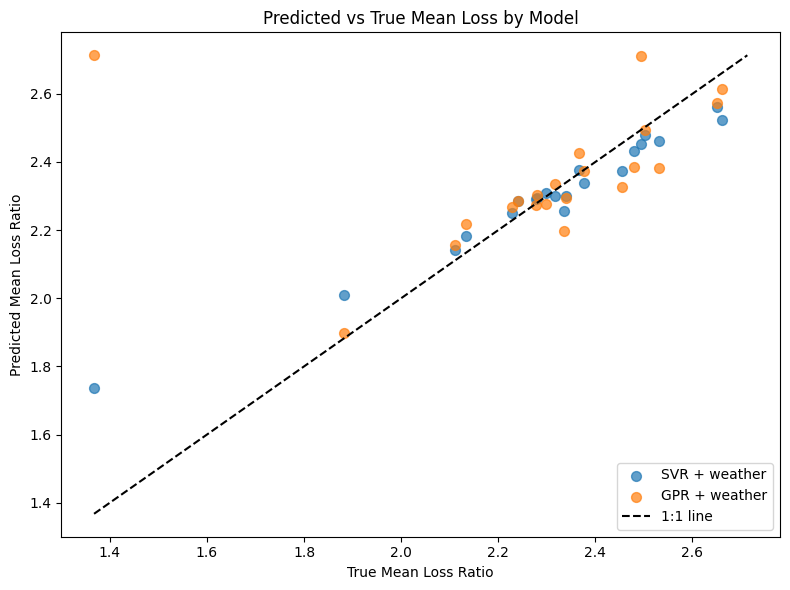

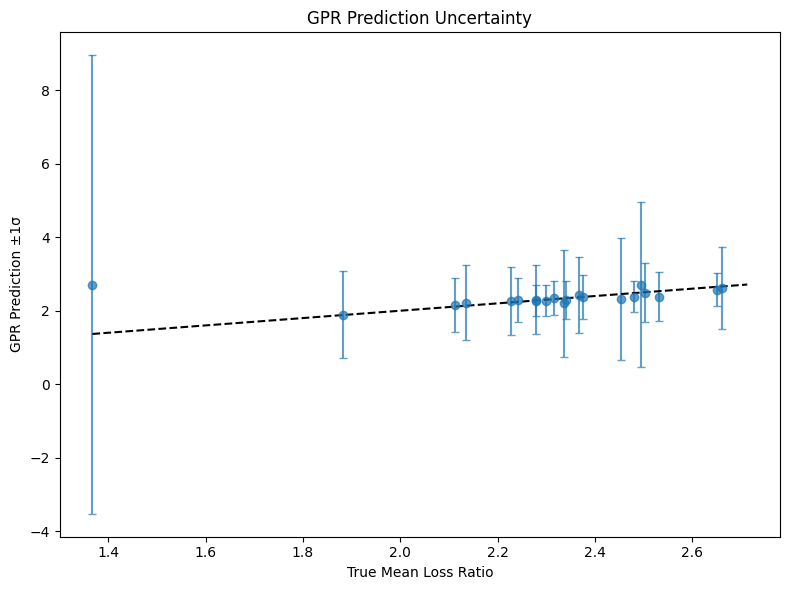

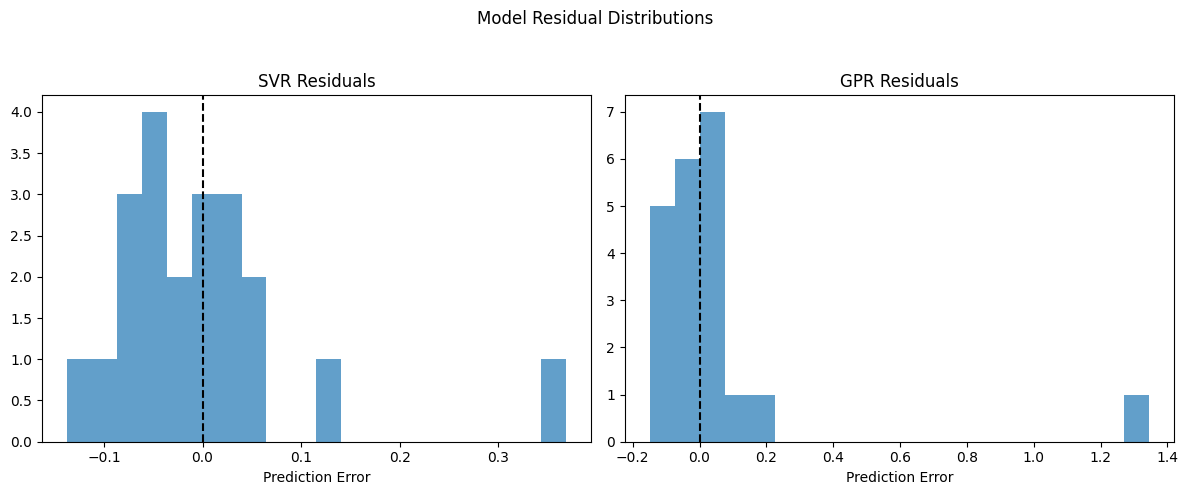

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# ── 1) Scatter: True vs. Predicted ─────────────────────────────────────────
plt.figure(figsize=(8,6))
plt.scatter(results['y_true'], results['svr+weather'],
            label='SVR + weather', alpha=0.7, s=50)
plt.scatter(results['y_true'], results['gpr+weather'],
            label='GPR + weather', alpha=0.7, s=50)

# 1:1 reference line:
lo = min(results[['y_true','svr+weather','gpr+weather']].min())
hi = max(results[['y_true','svr+weather','gpr+weather']].max())
plt.plot([lo, hi], [lo, hi], 'k--', label='1:1 line')

plt.xlabel('True Mean Loss Ratio')
plt.ylabel('Predicted Mean Loss Ratio')
plt.title('Predicted vs True Mean Loss by Model')
plt.legend()
plt.tight_layout()
plt.show()

# ── 2) GPR Predictions with Uncertainty ──────────────────────────────────
plt.figure(figsize=(8,6))
plt.errorbar(
    results['y_true'], results['gpr+weather'],
    yerr=results['gpr_std'], fmt='o', alpha=0.7, capsize=3
)
plt.plot([lo, hi], [lo, hi], 'k--')
plt.xlabel('True Mean Loss Ratio')
plt.ylabel('GPR Prediction ±1σ')
plt.title('GPR Prediction Uncertainty')
plt.tight_layout()
plt.show()

# ── 3) Residual Histograms ───────────────────────────────────────────────
res_svr = results['svr+weather'] - results['y_true']
res_gpr = results['gpr+weather'] - results['y_true']

fig, axs = plt.subplots(1, 2, figsize=(12,5))
bins = 20

axs[0].hist(res_svr, bins=bins, alpha=0.7)
axs[0].axvline(0, color='k', linestyle='--')
axs[0].set_title('SVR Residuals')
axs[0].set_xlabel('Prediction Error')

axs[1].hist(res_gpr, bins=bins, alpha=0.7)
axs[1].axvline(0, color='k', linestyle='--')
axs[1].set_title('GPR Residuals')
axs[1].set_xlabel('Prediction Error')

plt.suptitle('Model Residual Distributions')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
